# Case_study_7_2

The logistic loss function with a $L_2$ regularisation term is defined by:
$$
\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n} \log(1+\exp{(-y_i {\bf{w}}^T{\bf{x}}_i)}) + \frac{\lambda}{2}\left\Vert {\bf{w}}\right\Vert _{2}^{2}
$$

To solve it using ADMM we must split it into two parts: $g({\bf{w}})$ and $h({\bf{z}})$, being the last one the regularisation term. 

Taking into account that the gradient of $g({\bf{w}})$ is

$$
\nabla g({\bf{w}}) = \frac{1}{n} \sum_{i=1}^n -y_i {\bf{x}}_i\left( \frac{1}{1 + \exp{(y_i {\bf{w}}^T{\bf{x}}_i)}} \right)
$$

To apply the ADMM algorithm, the ${\bf{w}}_{k+1}$ step can addressed using a gradient-based algorithm and ${\bf{z}}_{k+1}$ can be solved using the prox_quadratic function. 

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_classification
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, BFGS, admm_logistic, calculation_Hessian_logistic, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=4
data_class, set_up=scenarios_classification(scenario)

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.logistic(cp.multiply(-Y,(X @ w))))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_logistic_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

grad_logistic_L2 =  lambda n, X, Y, w, lambd: ((1/n)*np.sum((np.diag(-Y.flatten())@X)/np.kron(1+np.exp(np.diag(Y.flatten())@(X@w.reshape(-1,1))),np.ones((1,len(w)))),axis=0).T + lambd*w)
hess_logistic_L2 = calculation_Hessian_logistic
grad_logistic_proximal = lambda n, X, Y, w, ro, a: ((1/n)*np.sum((np.diag(-Y.flatten())@X)/np.kron(1+np.exp(np.diag(Y.flatten())@(X@w.reshape(-1,1))),np.ones((1,len(w)))),axis=0).T+ro*(w-a))

# Solution of the empirical risk using CVX
#=========================================
w_L2_cvx=solver_cvx(set_up,loss_logistic_L2);

w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx
loss_opt=loss_logistic_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value                                                                                
                                          
# Gradient descent
out_gd = grad_FOM(set_up,grad_logistic_L2)
loss_grad=eval_loss(out_gd,set_up,loss_logistic_L2)                                         
                                          
# Newton algorithm
out_hess =grad_SOM(set_up,grad_logistic_L2,hess_logistic_L2)
loss_hess=eval_loss(out_hess,set_up,loss_logistic_L2)

# BFGS algorithm
out_BFGS =BFGS(set_up,grad_logistic_L2)
loss_BFGS=eval_loss(out_BFGS,set_up,loss_logistic_L2)   

# ADMM algorithm
out_admm =admm_logistic(set_up,grad_logistic_proximal)
loss_admm=eval_loss(out_admm,set_up,loss_logistic_L2)


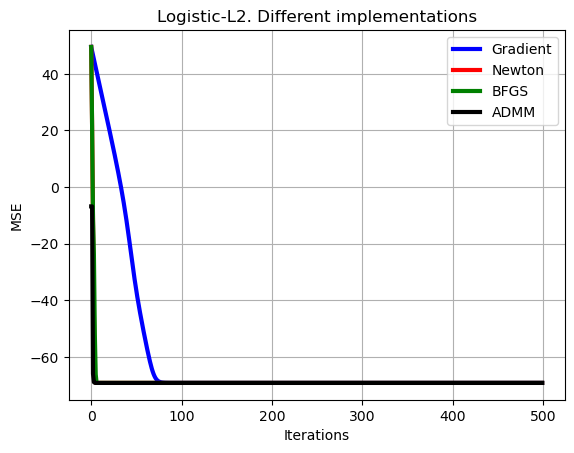

In [5]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)+np.finfo(np.float32).eps),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)+np.finfo(np.float32).eps),color='r', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_BFGS-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)+np.finfo(np.float32).eps),color='g', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_admm-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)+np.finfo(np.float32).eps),color='black', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(['Gradient','Newton','BFGS','ADMM'])
plt.title('Logistic-L2. Different implementations')
plt.show()